### Introduction
 In this notebook, we will explore the simulated maps and dataset for the foreground components, we will then perfom foreground-removal excercise and later
add white instrumental noise for each channel 




####

#### dependencies needed

* numpy
* healpy
* astropy
* matplotlib

In [518]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import h5py
import healpy as hp
import sys
import configparser

In [519]:
print(sys.executable)

config = configparser.ConfigParser()

config.read('../Foregrounds/parameters.ini')

/users/topol/.conda/envs/meerkat_env/bin/python


['../Foregrounds/parameters.ini']

We have:

* Cosmological signal
* Galactic synchrotron
* Galactic free-free
* Extragalactic point sources and background

In [520]:
# load the data 
# file_path = '../data/'
with fits.open('../Foregrounds/foreground_cube_2025.fits') as hdul:
    foreground_cube = hdul[0].data

with fits.open('../Foregrounds/cmb_cube_2025.fits') as hdul:
    cmb = hdul[0].data

with fits.open('../Foregrounds/free_free_cube_2025.fits') as hdul:
    free_free = hdul[0].data

with fits.open('../Foregrounds/point_sources_cube_2025.fits') as hdul:
    ps = hdul[0].data


with fits.open('../21 cm/map_n-2_nc-252_ns-256_bw-mwa-32float_nreal-1.fits') as hdul:
    map_21cm = hdul[0].data
    header_21cm = hdul[0].header


# synch
with fits.open('../Synch/DGSE_n-2_nc-252_ns-256_bw-mwa-32float_syncmod-1.fits') as hdul:
    map_synch = hdul[0].data
    header_synch = hdul[0].header


# header info 
print(header_21cm.get('BUNIT'))
print('\n\n', header_synch)

None


 SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =               786432                                                  NAXIS2  =                  252                                                  EXTEND  =                    T                                                  ORIGIN  = 'Converted from .npy'                                                 FILENAME= 'DGSE_n-2_nc-252_ns-256_bw-mwa-32float_syncmod-1.npy'                 END                                                                                                                                                                                                                                                                                                                                                             

In [521]:
# dimensions
print(f'foreground cube shape: {foreground_cube.shape}')
print(f'cmb shape: {cmb.shape}')
print(f'free free shape: {free_free.shape}')

print(f'21 cm shape: {map_21cm.shape}')
print(f'Synch shape: {map_synch.shape}')

foreground cube shape: (250, 786432)
cmb shape: (250, 786432)
free free shape: (250, 786432)
21 cm shape: (252, 786432)
Synch shape: (252, 786432)


In [522]:
print('21 cm min/max:', np.min(map_21cm), np.max(map_21cm))
print('Synch min/max:', np.min(map_synch), np.max(map_synch))

21 cm min/max: -1.0868233 1.0613836
Synch min/max: 0.1759276 126.55125


###

### The total number of pixels on the sphere, `Npix` is given by:
$Npix = 12 * n_s^2$

In [523]:
# Nside from healpix
nside_cmb = hp.get_nside(cmb)
nside_free_free = hp.get_nside(free_free)
nside_21cm = hp.get_nside(map_21cm)
nside_synch = hp.get_nside(map_synch)
nside_foreground_cube = hp.get_nside(foreground_cube)

# print nside for each
print(f'The Nside for 21 cm: {nside_21cm}')
print(f'The Nside for synch: {nside_synch}')
print(f'The Nside for cmb: {nside_cmb}')
print(f'The Nside for free free: {nside_free_free}')
print(f'The Nside for foreground cube: {nside_foreground_cube}')

The Nside for 21 cm: 256
The Nside for synch: 256
The Nside for cmb: 256
The Nside for free free: 256
The Nside for foreground cube: 256


In [524]:
# nside for free free
npix_ff = 786432
nside_ff = int(np.sqrt(npix_ff / 12))
print(nside_ff)

256


In [525]:
# pixels and map for h1
npix_21cm = hp.nside2npix(nside_21cm)
npix_synch = hp.nside2npix(nside_synch)
npix_cmb = hp.nside2npix(nside_cmb)
npix_foreground = hp.nside2npix(nside_foreground_cube)


print(f'The npix for 21cm: {npix_21cm}')
print(f'The npix for synch: {npix_synch}')
print(f'The npix for cmb: {npix_cmb}')

The npix for 21cm: 786432
The npix for synch: 786432
The npix for cmb: 786432


In [526]:
# check the temperature range
print(f'Min temperature for 21 cm: {np.min(map_21cm):.3f} mK')
print(f'Min temperature for synch: {np.min(map_synch):.3f} K')
print(f'Min temperature for cmb: {np.min(cmb):.3f} mK')
print(f'Min temperature for ...: {np.min(foreground_cube):.3f} mK')
print(f'Min temperature for free free: {np.min(free_free):.3f} mK \n\n')


# max
print(f'Max temperature for 21 cm: {np.max(map_21cm):.3f} mK')
print(f'Max temperature for synchrotron: {np.max(map_synch):.3f} mK')
print(f'Max temperature for cmb: {np.max(cmb):.3f} mK')
print(f'Max temperature for free free: {np.max(free_free):.3f} mK')
print(f'Max temperature for ...: {np.max(foreground_cube):.3f} K')

Min temperature for 21 cm: -1.087 mK
Min temperature for synch: 0.176 K
Min temperature for cmb: -0.488 mK
Min temperature for ...: 0.638 mK
Min temperature for free free: -0.007 mK 


Max temperature for 21 cm: 1.061 mK
Max temperature for synchrotron: 126.551 mK
Max temperature for cmb: 0.503 mK
Max temperature for free free: 68567.664 mK
Max temperature for ...: 70284.977 K


###

In [527]:
# converting everything into mK
foreground_cube = foreground_cube * 1000.0
map_synch = map_synch * 1000.0
ps = ps / 1000

#### MeerKAT UHF band, which is roughly 0.58 – 1.015 GHz according to the MeerKLASS UHF setup (see \ref MeerKLASS (2028))

The physical frequency for channel i is:
$f_i = f_m + i \Delta f$

Where:
- i are the channels
- $f_m$ minimum frequency
- $\Delta f$ the frequency width

In [528]:
# freq range with corresponding channel
fmin   = float(config['General']['freq_min'])                    # GHz
df     = float(config['General']['freq_width'])                      # GHz per channel
#fmax = 1.015 

print(df)

0.021


In [529]:
def freq_i(i):
    return (fmin + i*df)

'''The max channel i that corresponds to the frequency range of MeerKAT  i = 0-5 '''
indices = list(range(0, 1))                  # channels 0 to 3

In [530]:
'''import Foregrounds.foregrounds as fg
import numpy as np

def unit_probe(component_func, freqs_GHz, **kwargs):
    

    mA = component_func(freqs_GHz, **kwargs)[len(freqs_GHz)//2]     
    mB = component_func(freqs_GHz*1e9, **kwargs)[len(freqs_GHz)//2] 
    return np.std(mA), np.std(mB)


for i in indices:
    std_ff_GHz, std_ff_Hz = unit_probe(
        lambda nu, **kw: fg.free_free(nu, nside=256, **kw),
        freq_i(i), model_template=free_free['model_template'], temp_electron=float(free_free['temp_electron'])
    )
    print("free-free std(GHz), std(Hz) =", std_ff_GHz, std_ff_Hz)'''

'import Foregrounds.foregrounds as fg\nimport numpy as np\n\ndef unit_probe(component_func, freqs_GHz, **kwargs):\n    \n\n    mA = component_func(freqs_GHz, **kwargs)[len(freqs_GHz)//2]     \n    mB = component_func(freqs_GHz*1e9, **kwargs)[len(freqs_GHz)//2] \n    return np.std(mA), np.std(mB)\n\n\nfor i in indices:\n    std_ff_GHz, std_ff_Hz = unit_probe(\n        lambda nu, **kw: fg.free_free(nu, nside=256, **kw),\n        freq_i(i), model_template=free_free[\'model_template\'], temp_electron=float(free_free[\'temp_electron\'])\n    )\n    print("free-free std(GHz), std(Hz) =", std_ff_GHz, std_ff_Hz)'

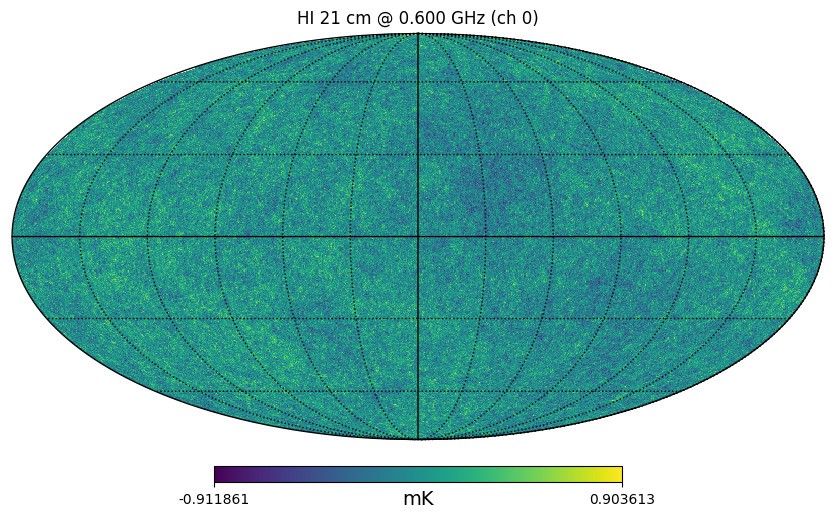

In [560]:
# Plot
for i in indices:
    freq_ghz = float(freq_i(i))
    
    # 21 cm
    hp.mollview(map_21cm[i, :],
                title=f'HI 21 cm @ {freq_ghz:.3f} GHz (ch {i})',
                unit='mK',
                
                )
    
    hp.graticule()
plt.show()

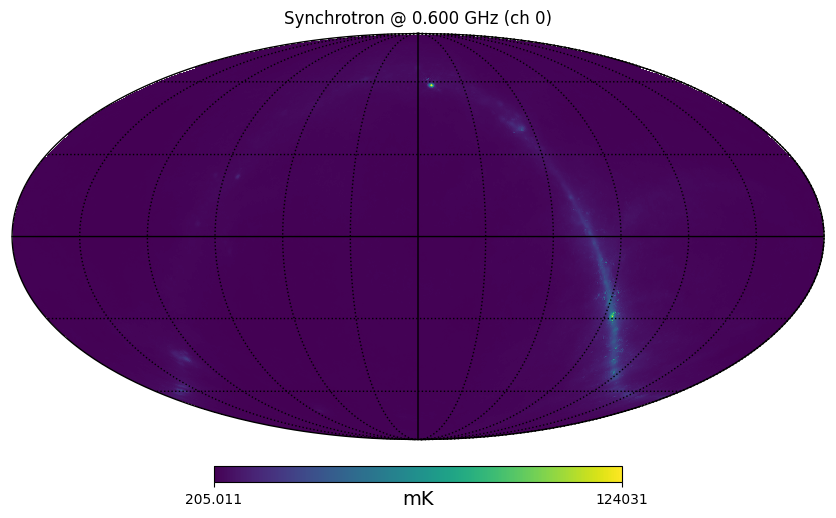

In [532]:
# Plot
for i in indices:
    freq_ghz = float(freq_i(i))
    
    # Synchrotron 
    hp.mollview(map_synch[i, :],
                title= f'Synchrotron @ {freq_ghz:.3f} GHz (ch {i})',
                unit='mK')
    hp.graticule()
plt.show()

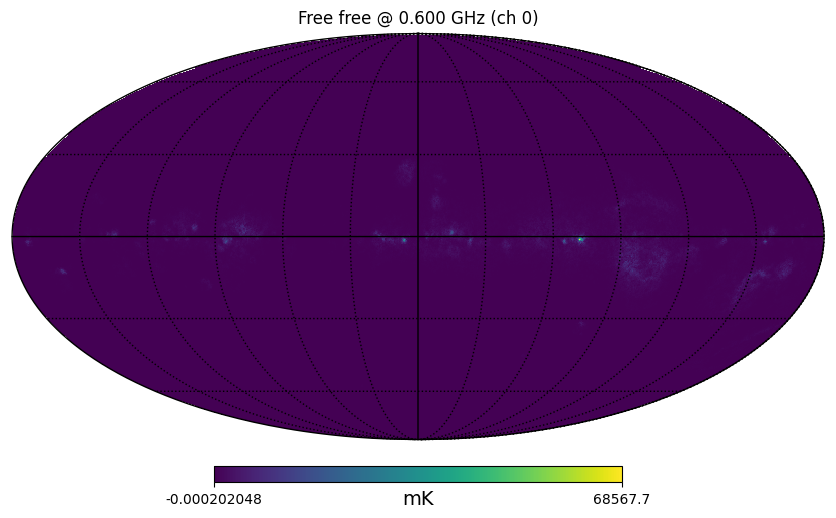

In [533]:
# Plot free free
for i in indices:
    freq_ghz = float(freq_i(i))

    # free free
    hp.mollview(free_free[i, :],
                title= f'Free free @ {freq_ghz:.3f} GHz (ch {i})',
                unit='mK',
    )
    hp.graticule()
plt.show()

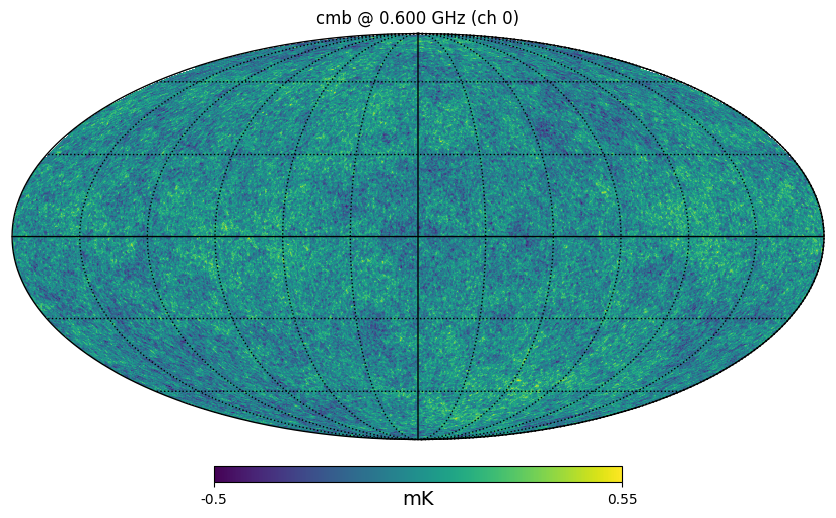

In [534]:
# Plot
for i in indices:
    freq_ghz = float(freq_i(i))

    # cmb
    hp.mollview(cmb[i, :],
                title= f'cmb @ {freq_ghz:.3f} GHz (ch {i})',
                min= -0.5, max=0.55,
                unit= 'mK')
    hp.graticule()
plt.show()

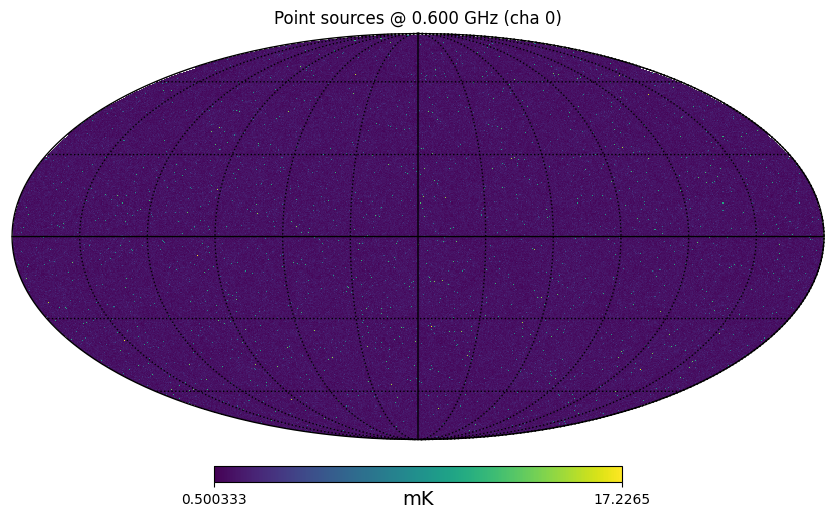

In [535]:
# Plot ps
for i in indices:
    freq_ghz = float(freq_i(i))

    # point sources
    hp.mollview(ps[i,:], 
                title= f'Point sources @ {freq_ghz:.3f} GHz (cha {i})',
                unit= 'mK')
    hp.graticule()

plt.show()

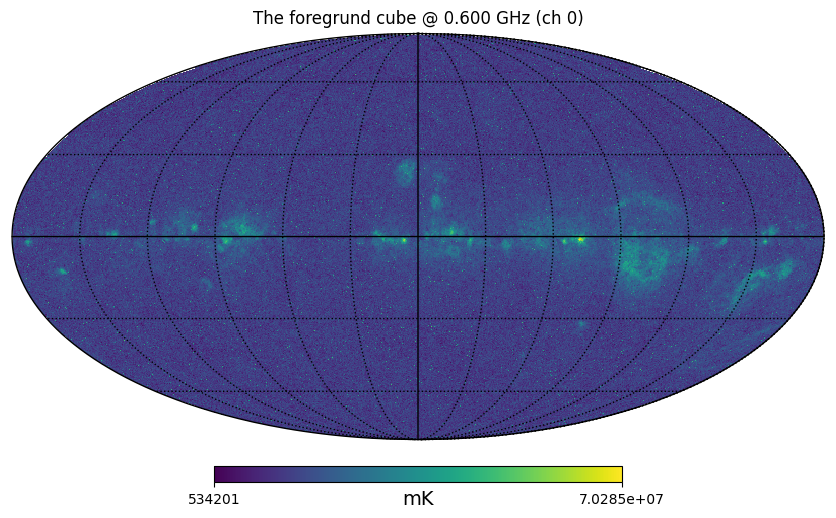

In [536]:
# foreground cube
hp.mollview(foreground_cube[i, :],
            title= f'The foregrund cube @ {freq_ghz:.3f} GHz (ch {i})',
            unit='mK',
            norm= 'log',
)

hp.graticule()
plt.show()

###

#### Angular power spectrum $C_{\ell}$



To compute the angular power spectrum, we analyze the statistical properties of the sky maps in harmonic space.

$a_{\ell m} = \int Y^*_{\ell m}(\theta, \phi) \, T(\theta, \phi) \, d\Omega$

where $T(\theta, \phi)$ is the brightness temperature of map and $Y_{\ell m}(\theta, \phi)$ are the spherical harmonics.

The angular power spectrum is then defined as the variance of these coefficients at each multipole $\ell$:

$
C_\ell = \frac{1}{2\ell + 1} \sum_{m=-\ell}^{\ell} |a_{\ell m}|^2
$


In practice, for HEALPix maps, we compute $C_\ell$ using the `healpy` package

##

In [537]:
def freq_i(i):
    return (fmin + i*df)

'''The max channel i that corresponds to the frequency range of MeerKAT  i = 0-5 '''
indices = list(range(0, 1))                  # channels 0 to 3

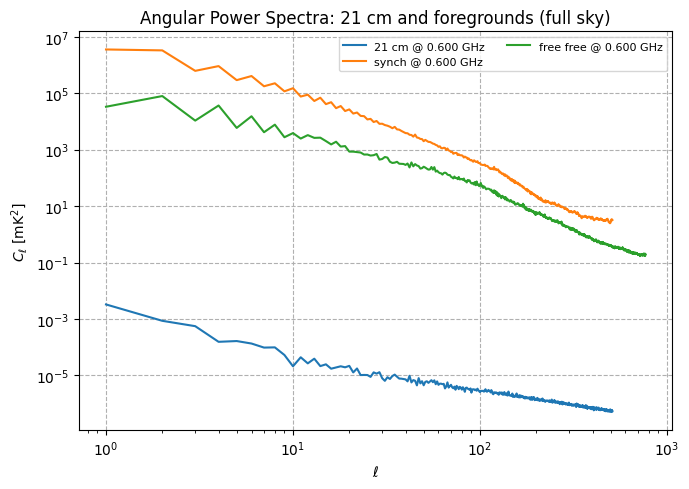

In [538]:
nside = 256
ell_max = 2 * nside  

plt.figure(figsize=(7,5))

for i in indices:
    freq_ghz = freq_i(i)  # frequency in GHz

    # 21 cm 
    cl_21cm =hp.sphtfunc.anafast(map_21cm[i])
    ell = np.arange(len(cl_21cm))
    plt.loglog(ell[1:ell_max], cl_21cm[1:ell_max],
               linestyle='-', label=f'21 cm @ {freq_ghz:.3f} GHz')

    # synchrotron 
    cl_synch = hp.anafast(map_synch[i])
    ell = np.arange(len(cl_synch))
    plt.loglog(ell[1:ell_max], cl_synch[1:ell_max],
               linestyle='-', label=f'synch @ {freq_ghz:.3f} GHz')
    
    # free free Cl
    cl_ff = hp.anafast(free_free[i])
    plt.loglog(np.arange(len(cl_ff))[1:], cl_ff[1:], linestyle='-',
               label=f'free free @ {freq_ghz:.3f} GHz')
    
    # forgrounds Cl total
    '''cl_foregrounds = hp.anafast(foreground_cube[i])
    plt.loglog(np.arange(len(cl_foregrounds))[1:], cl_foregrounds[1:], linestyle='-',
               label=f'Total foregrounds @ {freq_ghz:.3f} GHz')'''
    

    # Angular power spectra for cmb 
    '''cl_cmb = hp.anafast(cmb[i])
    ell = np.arange(len(cl_cmb))

    # Find the ℓ where the spectrum starts decreasing (after the first peak)
    peak_idx = np.argmax(cl_cmb)                    # index of maximum power
    ell_crop = ell[peak_idx:]
    cl_crop = cl_cmb[peak_idx:]

    plt.loglog(ell_crop[1:], cl_crop[1:], linestyle='-',
               label=f'cmb @ {freq_ghz:.3f} GHz')'''
    
    # Angular power spectra for point sources
    # p-s Cl

    '''cl_ps = hp.anafast(ps[i])
    plt.loglog(np.arange(len(cl_ps))[1:], cl_ps[1:], linestyle='-',
               label=f'ps @ {freq_ghz:.3f} GHz')'''
    
    


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$ [mK$^2$]')
plt.title('Angular Power Spectra: 21 cm and foregrounds (full sky)')
plt.grid(True, ls='--')
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


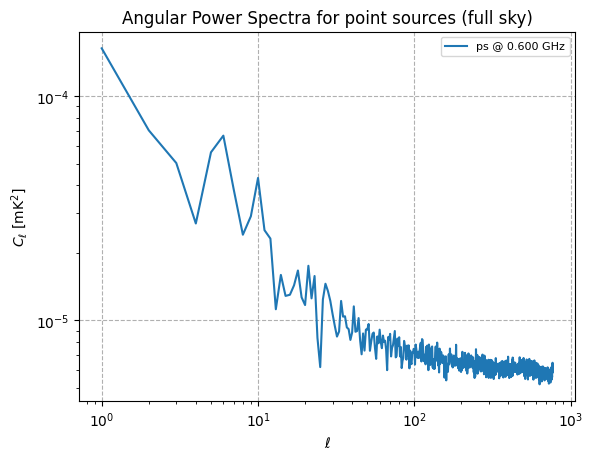

In [539]:
# Angular power spectra for point sources
for i in indices:
    freq_ghz = freq_i(i)  # frequency in GHz
    
    # p-s Cl
    cl_ps = hp.anafast(ps[i])
    plt.loglog(np.arange(len(cl_ps))[1:], cl_ps[1:], linestyle='-',
               label=f'ps @ {freq_ghz:.3f} GHz')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$ [mK$^2$]')
plt.title('Angular Power Spectra for point sources (full sky)')
plt.grid(True, ls='--')
plt.legend(fontsize=8, ncol=2)

plt.show()

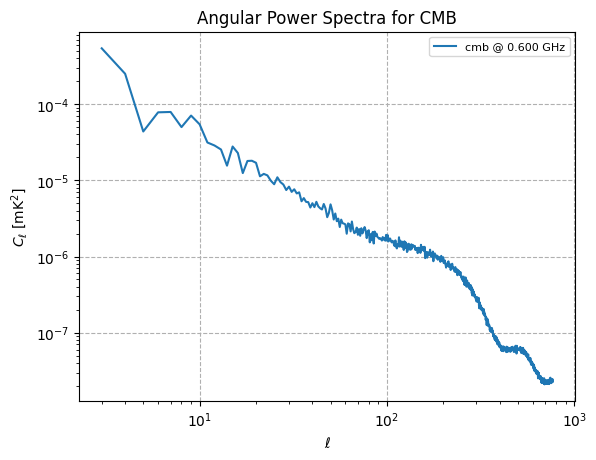

In [540]:
# Angular power spectra for cmb 
for i in indices:
    freq_ghz = freq_i(i)  # frequency in GHz
    
    # Compute Cℓ
    cl_cmb = hp.anafast(cmb[i])
    ell = np.arange(len(cl_cmb))

    # Find the ℓ where the spectrum starts decreasing (after the first peak)
    peak_idx = np.argmax(cl_cmb)   # index of maximum power
    ell_crop = ell[peak_idx:]
    cl_crop = cl_cmb[peak_idx:]

    plt.loglog(ell_crop[1:], cl_crop[1:], linestyle='-',
               label=f'cmb @ {freq_ghz:.3f} GHz')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$ [mK$^2$]')
plt.title('Angular Power Spectra for CMB')
plt.grid(True, ls='--')
plt.legend(fontsize=8, ncol=2)
plt.show()


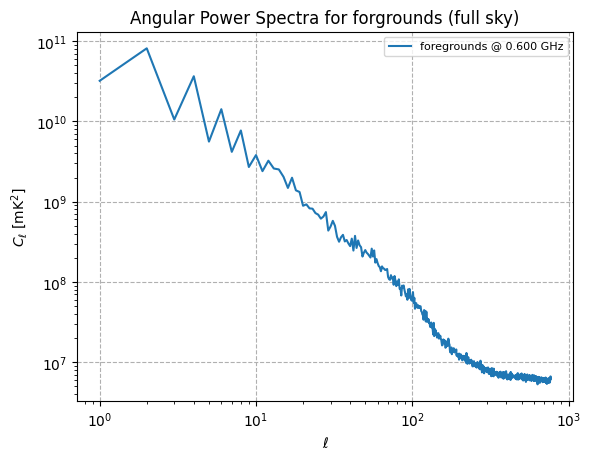

In [541]:
# Angular power spectra for foreground cube 
for i in indices:
    freq_ghz = freq_i(i)  # frequency in GHz
    
    # forgrounds Cl
    cl_foregrounds = hp.anafast(foreground_cube[i])
    plt.loglog(np.arange(len(cl_foregrounds))[1:], cl_foregrounds[1:], linestyle='-',
               label=f'foregrounds @ {freq_ghz:.3f} GHz')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$ [mK$^2$]')
plt.title('Angular Power Spectra for forgrounds (full sky)')
plt.grid(True, ls='--')
plt.legend(fontsize=8, ncol=2)
plt.show()

### Combining maps

`1. Full-sky  masking`

- HEALPix can have masked pixels (usually 0) for incomplete sky coverage.

- Binary mask: each pixel is either:

  $\space$  1 → valid pixel (include in analysis)

  $\space$  0 → masked/out-of-sky pixel (ignore)


- Then the Brightness temp can also be applied with mask

####                                                                   $T(\hat n) = \frac{\Sigma_i \space T(\hat n, f_i) \space * \space M(\hat n)}{\Sigma_i \space M}$

####

`2. Frequency weighting`

   
 ####                                                  $T(\hat n) = \Sigma_i w_i T(\hat n, f_i)$

 Where:
 - T is the brightness temperature in pixel $\hat n$ and $f_i$ 
 - $w_i$ are the weight for channel i => can be simply 1/N depending on paraters availlable

###

##


### Adding Maps into one map with dimensions of,
#### $N_{chan} \times N_{pix}$
####
### Each map will contribute to the total observed brightness temperature
#### $T(\nu , p) = T_{21} + T_{synch} + ..$

In [542]:
print('21 cm min/max:', np.min(map_21cm), np.max(map_21cm))
print('Synch min/max:', np.min(map_synch), np.max(map_synch))

21 cm min/max: -1.0868233 1.0613836
Synch min/max: 175.9276 126551.25


In [544]:
total_map = map_21cm + map_synch

In [545]:
hp.get_nside(total_map)

256

In [546]:
# dimensions
print(np.shape(total_map))
print(np.shape(map_21cm))

# min channel
min_ch = 5
print(min_ch)

(252, 786432)
(252, 786432)
5


In [ ]:
# 21cm map - prior for GNILC
prior_21cm = map_21cm[:min_ch, :].astype(np.float32)       # same slice
print(f'The shape for prior 21cm {prior_21cm.shape}')

# SAVE IT
hdu = fits.PrimaryHDU(prior_21cm)
hdu.header['NSIDE'] = 256
hdu.header['NCHAN'] = prior_21cm.shape[0]
hdu.writeto("../data/prior_21cm.fits", overwrite= True)
prior_21cm.mean()

The shape for prior 21cm (5, 786432)


-5.5420482e-08

In [548]:
# sum 21cm + foreground cube
map_LBand_in_mK = total_map[:min_ch, :]

In [549]:
# check shape
print('reduced shape:', map_LBand_in_mK.shape)

reduced shape: (5, 786432)


#### Save the .fits file - the mask and map_LBand_in_mK

In [550]:
# ensure its float32
map_LBand_in_mK = map_LBand_in_mK.astype(np.float32)

# HDU
hdu = fits.PrimaryHDU(map_LBand_in_mK)


hdu.header['NSIDE'] = 256
hdu.header['NCHAN'] = map_LBand_in_mK.shape[0]

# Write to file
hdu.writeto("../data/map_LBand_in_mK.fits", overwrite= True)

print("Saved combined map as map_LBand_in_mK.fits")

Saved combined map as map_LBand_in_mK.fits


In [551]:
map_LBand_in_mK.shape
hp.get_nside(map_LBand_in_mK)

256

#### Next step is to test GNILC on path ~ `GNILC`

In [552]:
#hp.mollview(map_LBand_in_mK[0])

In [553]:
n_channels, n_pixels = map_LBand_in_mK.shape
nside_total_map = hp.npix2nside(n_pixels)

print(f"Number of frequency maps (channels): {n_channels}")
print(f"Nside: {nside_total_map}")
print(f"3 * Nside - 1 = {3 * nside_total_map - 1}")

Number of frequency maps (channels): 5
Nside: 256
3 * Nside - 1 = 767


In [554]:
map_LBand_in_mK.shape

(5, 786432)

In [555]:
print(hp.get_nside(map_LBand_in_mK))

256


In [556]:
npix_total_map = hp.nside2npix(nside_total_map)

In [557]:
# full sky masking
mask = np.ones(npix_total_map, dtype= np.float32)  # 1D array of all ones

hp.write_map("../data/mask.fits", mask, overwrite=True)
print("Full-sky mask saved")

setting the output map dtype to [dtype('float32')]


Full-sky mask saved


In [558]:
prior_21cm.shape

(5, 786432)

In [559]:
print(f'The min of prior {np.mean(prior_21cm)}')
print((f'The min for 21 cm map {np.mean(map_21cm)}'))

The min of prior -5.542048242546116e-08
The min for 21 cm map 1.4095261846591711e-08
